# Automatic Transactional Systems: Project

Authors: Adam Foster and Maciek Staniszewski

# Introduction

Forecasting stock prices has been a well-known challenge for financial analysts. As part of our final project we forecasted returns and close prices of a time series of a chosen stock (Johnson & Johnson). We developed two models: AR-GARCH and LSTM for return/price prediction. We built a long-short trading setup based on signals from these predictions. We assessed performance of each of the models using Sharpe ratio on the out-of-sample period, which consistuted the last 10% of the time series.

Global variables were defined to be used across both trading strategies. They were initialized with capital letters.

In [103]:
TRANSACTION_COSTS = 0.0005 # cost is 5bps of trade value

# Literature Review

AR (Autoregressive) models are frequently used across statistics; also in trading stratgies, as they provide a framework for explaining variables with lagged iterations of the variables. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are widely used in trading strategies for their ability to model and forecast volatility in financial time series, capturing time-varying volatility clustering effectively. LSTM (Long Short-Term Memory) models, a type of recurrent neural network, excel in handling sequential data and capturing long-term dependencies, making them suitable for predicting stock prices and trends based on historical data. Recent studies highlight that while GARCH models are robust in volatility prediction, LSTM models often outperform in price prediction due to their non-linear processing capabilities. Combining both models can leverage GARCH's strength in volatility estimation and LSTM's prowess in trend prediction, potentially enhancing trading strategy performance.

# Data: AR-GARCH

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

Johnson & Johnson, a pharmaceutical company listed on the NYSE, was chosen for this project. It is a well established company contributing to the S&P500 index with no long-term directional movement in price over the last several years. It is a good candidate for testing the true power of autoregressive and machine learning models and displays high liquidity.

Instead of 6 years of close prices, 2 months of 5-minute prices from 19/04/2024-07/06/2024 were used. This translated to 2574 observations, more than the required 1512 (252 trading days x 6 years alternative).

As a fallback, missing values were populated with last available observations. Log returns were calculated on close prices and scaled by 1000 for model calibration to prevent obtaining inaccurate and spurious results. These were converted back for calculating P&L.

In [105]:
jnj_raw = pd.read_csv('../jnj.us.txt')[["<DATE>", "<TIME>", "<OPEN>", "<CLOSE>"]].rename(columns={'<DATE>' :  'Date',
                                                                                                    '<TIME>':   'Time',
                                                                                                    '<OPEN>':   'Open',
                                                                                                    '<CLOSE>':  'Close'})
jnj_raw

,Date,Time,Open,Close
0,20240419,153000,146.150,144.8000
1,20240419,153500,144.800,145.4200
2,20240419,154000,145.440,145.6200
3,20240419,154500,145.660,145.9858
4,20240419,155000,145.975,146.1800
...,...,...,...,...
2569,20240607,213500,147.250,147.1700
2570,20240607,214000,147.170,147.0500
2571,20240607,214500,147.050,146.9300
2572,20240607,215000,146.930,147.1700


In [106]:
jnj_raw['DateStr'] = jnj_raw['Date'].astype(str)
jnj_raw['TimeStr'] = jnj_raw['Time'].astype(str)

jnj_raw['Date'] = jnj_raw['DateStr'].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:]}")
jnj_raw['Time'] = jnj_raw['TimeStr'].apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:]}")

jnj_raw['Datetime'] = pd.to_datetime(jnj_raw['DateStr'] + ' ' + jnj_raw['TimeStr'])
jnj_raw = jnj_raw.drop(columns = ['Open'])
jnj_raw = jnj_raw.rename(columns = {'Close': 'JNJ'})

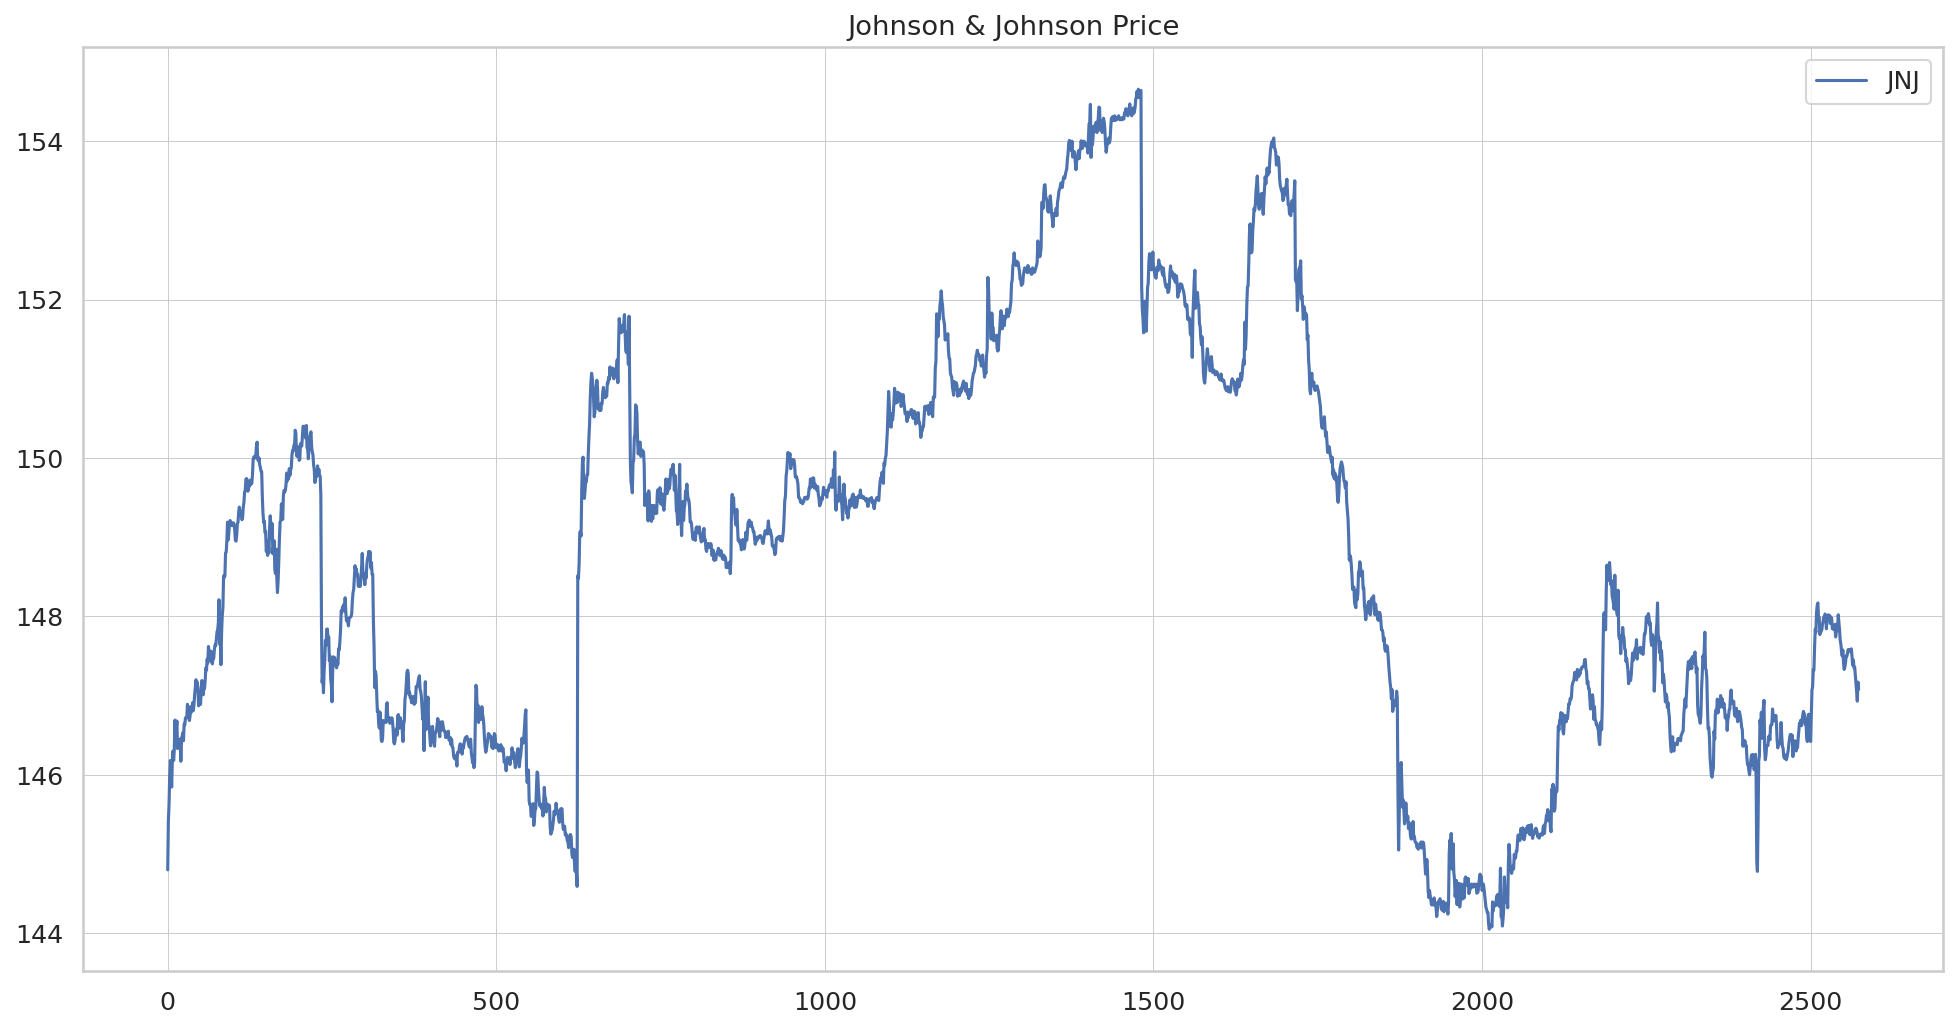

In [107]:
plt.figure(figsize=(16, 8), dpi=150) 

jnj_raw['JNJ'].plot(label='JNJ')
plt.title('Johnson & Johnson Price')
plt.legend()

In [108]:
returns = jnj_raw.fillna(method='ffill')
tickers = ['JNJ']

for ticker in tickers:
    returns['Ret_' + ticker] = (np.log(returns[ticker]) - np.log(returns[ticker].shift(1))) * 1000 # series scaled by 1000 to enable accurate calibration

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

/tmp/ipykernel_6274/2988824415.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = jnj_raw.fillna(method='ffill')


,Date,Time,JNJ,DateStr,TimeStr,Datetime,Ret_JNJ
1,2024-04-19,15:35:00,145.4200,20240419,153500,2024-04-19 15:35:00,4.272627
2,2024-04-19,15:40:00,145.6200,20240419,154000,2024-04-19 15:40:00,1.374382
3,2024-04-19,15:45:00,145.9858,20240419,154500,2024-04-19 15:45:00,2.508868
4,2024-04-19,15:50:00,146.1800,20240419,155000,2024-04-19 15:50:00,1.329382
5,2024-04-19,15:55:00,146.0800,20240419,155500,2024-04-19 15:55:00,-0.684322


# Statistics

In [109]:
class data_extraction:
    def __init__(self, data, asset):
        self.data = data
        self.asset = asset
        self.series = self.extract_series()

    def extract_series(self):
        return self.data[self.asset]

In [110]:
class analysis(data_extraction):
    def __init__(self, data, asset):
        data_extraction.__init__(self, data, asset)
        self.x = self.norm_dist()
    
    def acf_log_ret(self):
        plot_acf(self.series, lags=30, title='ACF Log Returns ' + self.asset)
        plt.show()
        
    def acf_sq_log_ret(self):
        plot_acf(self.series**2, lags=30, title='ACF Squared Log Returns ' + self.asset)
        plt.show()
        
    def describe(self):
        return describe(self.series)

    def norm_dist(self):
        mu, sigma = np.mean(self.series), np.std(self.series)
        x = np.random.normal(mu, sigma, 1000)
        x = pd.Series(x, name='Normal Distribution')
        return x
    
    def asset_hist_v_norm(self):
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax2.grid(False)
        ax1.hist(self.series, bins=30)
        g1 = sns.kdeplot(self.x, ax=ax2, color='r')
        g1.set(ylabel=None)
        g1.set(yticklabels=[])
        plt.title('Histogram vs Normal Distribution ' + self.asset);
    
    def asset_dist_v_norm(self):
        sns.set_style('whitegrid')
        series_norm = pd.concat([self.series, self.x], axis=1)
        sns.kdeplot(data=series_norm, bw_method=0.5)
        plt.title('Distribution vs Normal Distribution ' + self.asset);
    
    def arch_test(self):
        return het_arch(self.series)
    
    def arch_test_lag5(self):
        return het_arch(self.series, nlags=5)

In [111]:
analysis_jnj = analysis(returns, 'Ret_JNJ')

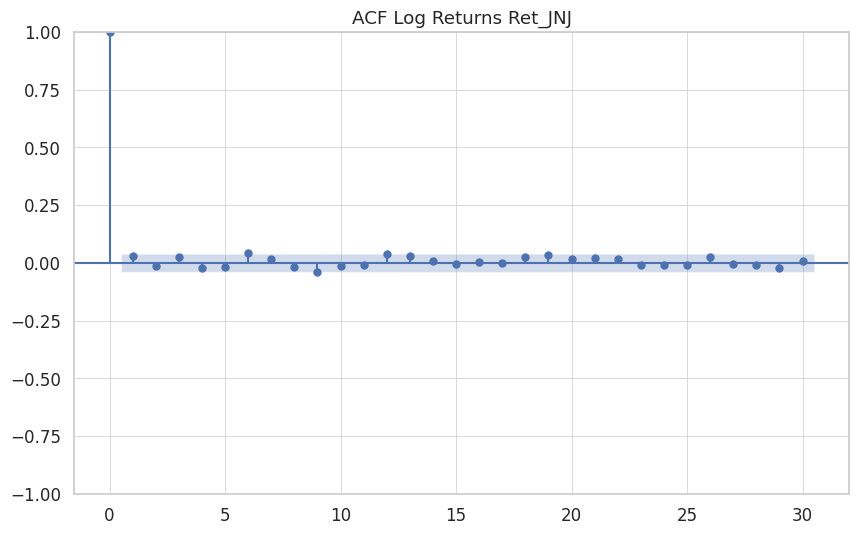

In [112]:
analysis_jnj.acf_log_ret()

ACF of log returns indicates some AR/MA property among returns with lags 1, 4, 6, 6 being or almost being statistically significant at 5% confidence level.

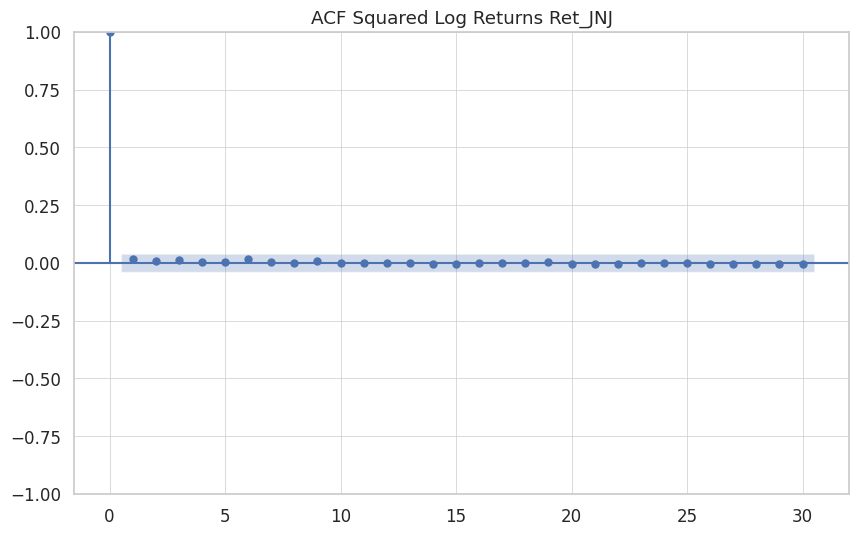

In [113]:
analysis_jnj.acf_sq_log_ret()

ACF of squared log returns indicates low likelihood of AR property among squared returns for (G)ARCH with lags not being statistically significant.

In [114]:
analysis_jnj.describe()

,Ret_JNJ
nobs,2.573000e+03
missing,0.000000e+00
mean,6.071969e-03
std_err,2.346566e-02
upper_ci,5.206382e-02
lower_ci,-3.991988e-02
std,1.190290e+00
iqr,8.986146e-01
iqr_normal,6.661440e-01
mad,6.749249e-01


- Positive skewness: larger positive returns than negative ones are prevalent, which is unusual for equities
- Very high kurtosis: fluctuations in returns resulting in much fatter tails than expected of a normal distribution; somewhat expected given the frequency of the data
- jarque_bera_pval close to zero: H0 normality rejected

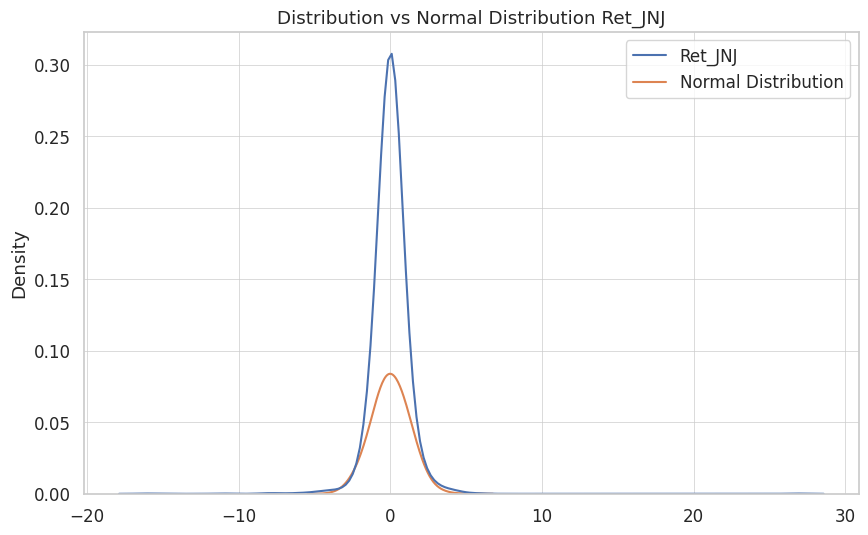

In [115]:
analysis_jnj.asset_dist_v_norm()

In [116]:
analysis_jnj.arch_test()

(2.035973237564, 0.9960569359573243, 0.202884681235908, 0.9960952426298892)

In [117]:
analysis_jnj.arch_test_lag5()

(1.0866108654935305,
 0.9552819430219457,
 0.2169061916290882,
 0.9554283519084472)

- H0 no arch effects not rejected (large p-value): likely no arch effects in data

There were some mixed results regarding persistence of returns of Johnson & Johnson equity price. Whilst there were no arch effects, there was some indication of autoregression in the mean equation and an opportunity to exploit the fat tails of the leptokurtic distribution.

# Methodology: AR-GARCH

## Model

The first model was AR-GARCH. The AR (autoregressive) component defines the mean equation and regresses the variable on lags of itself with the lags specified denoting the persistence. The GARCH (generalised autoregressive conditional heteroskedasticity) component defines the variance equation and regresses variance on lagged variance and lagged squared error terms.

AR orders of 1, 4, 6 and 9 were selected for different specifications of the model in line with the ACF plot from the Statistics section.

GARCH(p,q) variations of (1,1), (1,2) and (2,1) were tested in the absence of statistically significant squared log returns and general lack of model improvement beyond two lags.

The model variations were run on 90% of the dataset as the train set. The remaining 10% was left for the test set. A rolling window approach was incorporated, whereby the parameters calibrated during training were applied to datetimes in the test set sequentially, forecasting only the next period return and volatility at a time.

In [118]:
class garch_base(data_extraction):
    def __init__(self, approach, proportion, p, q, mean, data, asset, lags=0, o=0):
        data_extraction.__init__(self, data, asset)
        self.approach = approach
        self.proportion = proportion
        self.p = p
        self.o = o
        self.q = q
        self.mean = mean
        self.lags = lags
        self.train = self.series.iloc[:int(self.proportion*len(self.series))]
        self.test = self.series.iloc[int(self.proportion*len(self.series)):]
#         self.last_train_date = datetime.strftime(self.train.index[-1], '%Y-%m-%d')
        self.last_train_date = self.train.index[-1]
        self.res_garch = self.fit()
    
    def specs(self):
        return 'ar' + str(self.lags) + 'garch' + str(self.p) + str(self.q)

    def train_out(self):
        return self.train
    def fit(self):
        if self.approach == 'fixed':
            garch = arch.arch_model(self.train, mean=self.mean, lags=self.lags, vol='GARCH', p=self.p, o=self.o, q=self.q)
            res_garch = garch.fit()
        elif self.approach == 'roll1d':
            garch = arch.arch_model(self.series, mean=self.mean, lags=self.lags, vol='GARCH', p=self.p, o=self.o, q=self.q)
            res_garch = garch.fit(last_obs=self.last_train_date)
            
        return res_garch
    
    def summary(self):
        res_garch_summary = self.res_garch.summary()
        
        return res_garch_summary
    
    def plot(self):
        fig = self.res_garch.plot()
        plt.show()
    
    def autocorr(self):
        lb = acorr_ljungbox(self.res_garch.std_resid**2, [10, 15, 20])
        
        return lb
    
    def info_crit(self):
        ic_out = {'AIC': [self.res_garch.aic], 'BIC': [self.res_garch.bic]}
        ic = pd.DataFrame(data=ic_out)
        
        return ic
    
    def acf_stan(self):
        plot_acf(self.res_garch.std_resid, lags=30, title='ACF of Standardized Residuals')
        plt.show()
        
    def acf_sq_stan(self):
        plot_acf(self.res_garch.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
        plt.show()

class garch(garch_base):
    def __init__(self, approach, proportion, p, q, mean, data, asset, lags=0, o=0):
        garch_base.__init__(self, approach, proportion, p, q, mean, data, asset, lags, o)
        self.forecast = self.forecast()
        self.exclusion_dates = self.get_exclusion_dates()
        self.forecast_mean_values = self.forecast_mean_values()
        self.forecast_std_values = self.forecast_std_values()
        self.forecast_vs_test = self.forecast_vs_test()

    def forecast(self):
        forecast = self.res_garch.forecast(horizon=len(self.test))
        
        return forecast
    
#     def forecast_out(self):
#         return self.forecast
    
    def get_exclusion_dates(self):
#         return [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= self.last_train_date]
        return [i for i in self.forecast.mean.index.tolist() if i <= self.last_train_date]
    
    def forecast_mean_values(self):
        if self.approach == 'fixed':
            forecast_mean_values = self.forecast.mean.iloc[0]
        elif self.approach == 'roll1d':
            forecast_mean_values = self.forecast.mean.drop(self.exclusion_dates)
            forecast_mean_values = forecast_mean_values.iloc[:,0]
        
        return forecast_mean_values
    
    def forecast_mean(self):
#         forecast_mean = self.forecast.mean
#         forecast_mean.iloc[0].plot()
        self.forecast_mean_values.plot()

    def forecast_std_values(self):
        forecast_vol_raw = self.forecast.variance**0.5
        
        if self.approach == 'fixed':
            forecast_std_values = forecast_vol_raw.iloc[0]
        elif self.approach == 'roll1d':
            forecast_std_values = forecast_vol_raw.drop(self.exclusion_dates)
            forecast_std_values = forecast_std_values.iloc[:,0]
        
        return forecast_std_values
#         std3 = std2.transpose()
#         for i, col in enumerate(std3.columns):
#             std3[col] = std3[col].shift(i)
#         std3
#         std3.plot()
    
    def forecast_std(self):
#         forecast_stdev = self.forecast.variance**0.5
#         forecast_stdev.iloc[0].plot()
        self.forecast_std_values.plot()
    
    def forecast_vs_test(self):
#         if self.approach == 'fixed':
#             forecast_mean_values = self.forecast.mean.iloc[0].values
#         elif self.approach == 'roll1d':
#             exclusion_dates = [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= last_train_date]
#             forecast_mean_values = self.forecast.mean.drop(exclusion_dates)
#             forecast_mean_values = forecast_mean_values.iloc[:,0].values

        forecast_mean_values = self.forecast_mean_values.values
        
        forecast_mean = pd.Series(forecast_mean_values, index=self.test.index)
        self.train.rename('Ret_Train', inplace=True)
        self.test.rename('Ret_Test', inplace=True)
        forecast_mean.rename('Ret_Forecast', inplace=True)
        forecast_vs_test = pd.concat([self.train, self.test, forecast_mean], axis=1)

        forecast_vs_test['Ret_Test_Broad'] = forecast_vs_test[['Ret_Train','Ret_Test']].max(axis=1)

        forecast_vs_test['Vol_Train'] = forecast_vs_test[['Ret_Train']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test_Broad'] = forecast_vs_test[['Ret_Test_Broad']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test'] = np.where(forecast_vs_test['Ret_Test'].isna(), forecast_vs_test['Ret_Test'], forecast_vs_test['Vol_Test_Broad'])

#         forecast_vol_raw = self.forecast.variance**0.5
#         if self.approach == 'fixed':
#             forecast_std_values = forecast_vol_raw.iloc[0].values
#         elif self.approach == 'roll1d':
#             forecast_std_values = forecast_vol_raw.drop(exclusion_dates)
#             forecast_std_values = forecast_std_values.iloc[:,0].values
        
        forecast_std_values = self.forecast_std_values.values
        
        forecast_vs_test_condvol = pd.Series(forecast_std_values, index=self.test.index) #conditional vol
        forecast_vs_test_condvol.rename('Vol_Forecast', inplace=True)
        forecast_vs_test = pd.concat([forecast_vs_test, forecast_vs_test_condvol], axis=1)

        return forecast_vs_test
    
    def forecast_vs_test_mean_plot(self):
        self.forecast_vs_test[['Ret_Train','Ret_Test','Ret_Forecast']].plot()
        
    def forecast_vs_test_vol_plot(self):
        self.forecast_vs_test[['Vol_Train','Vol_Test','Vol_Forecast']].plot()

In [119]:
ar1garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_JNJ', 1)
ar1garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_JNJ', 1)
ar1garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_JNJ', 1)
ar4garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_JNJ', 4)
ar4garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_JNJ', 4)
ar4garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_JNJ', 4)
ar6garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_JNJ', 6)
ar6garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_JNJ', 6)
ar6garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_JNJ', 6)
ar9garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_JNJ', 9)
ar9garch12 = garch('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_JNJ', 9)
ar9garch21 = garch('roll1d', 0.9, 2, 1, 'AR', returns, 'Ret_JNJ', 9)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 61052.79280867893
Iteration:      2,   Func. Count:     17,   Neg. LLF: 6453202.524870855
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2149143.382759834
Iteration:      4,   Func. Count:     33,   Neg. LLF: 3517.4363591318224
Iteration:      5,   Func. Count:     40,   Neg. LLF: 3726.2849913105483
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3474.4284763938213
Iteration:      7,   Func. Count:     53,   Neg. LLF: 3468.286028036266
Iteration:      8,   Func. Count:     59,   Neg. LLF: 3466.453192727503
Iteration:      9,   Func. Count:     65,   Neg. LLF: 3466.4588223039746
Iteration:     10,   Func. Count:     72,   Neg. LLF: 3465.8531836189095
Iteration:     11,   Func. Count:     78,   Neg. LLF: 3465.8516812260423
Iteration:     12,   Func. Count:     84,   Neg. LLF: 3465.851670324504
Iteration:     13,   Func. Count:     90,   Neg. LLF: 3465.8516689144944
Iteration:     14,   Func. Count:     95,   Neg. LLF: 346

In [120]:
runs = [ar1garch11, ar1garch12, ar1garch21, ar4garch11, ar4garch12, ar4garch21, ar6garch11, ar6garch12, ar6garch21, ar9garch11, ar9garch12, ar9garch21]

for i, ic in enumerate(runs):
    ic_append = ic.info_crit()
    ic_append['Model'] = ic.specs()
    
    if i == 0:
        ics = ic_append
    else:
        ics = pd.concat([ics, ic_append])

cols = ics.columns.tolist()
cols = cols[-1:] + cols[:-1]
ics = ics[cols]
ics

,Model,AIC,BIC
0,ar1garch11,6941.703338,6970.437002
0,ar1garch12,6938.755516,6973.235914
0,ar1garch21,6943.703338,6978.183735
0,ar4garch11,6891.079006,6937.042491
0,ar4garch12,6873.357438,6925.066359
0,ar4garch21,6893.079006,6944.787926
0,ar6garch11,6881.235095,6938.680793
0,ar6garch12,6856.468085,6919.658353
0,ar6garch21,6883.235095,6946.425363
0,ar9garch11,6836.029749,6910.692255


It can be seen that across all model variations AR(9)-GARCH(1,2) had the lowest Akaike Information Criterion (AIC) and was the model of choice.

Representations of its mean and volatility forecasts are shown below.

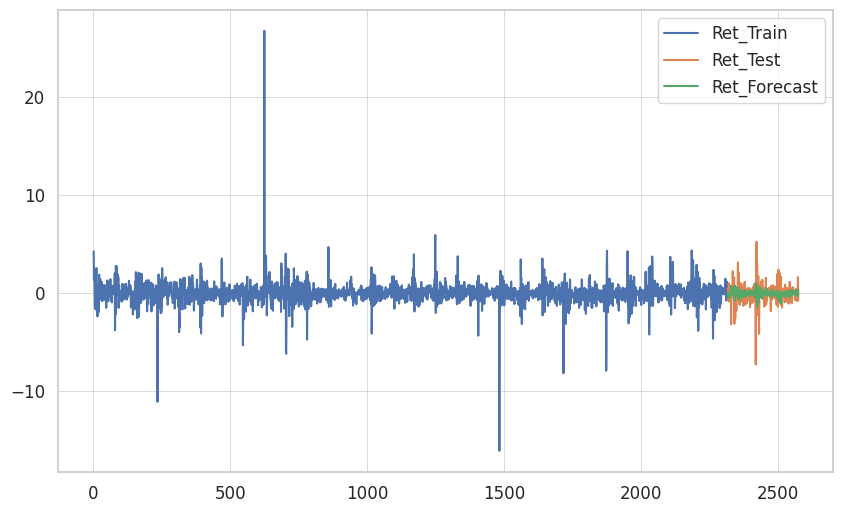

In [121]:
ar9garch12.forecast_vs_test_mean_plot()

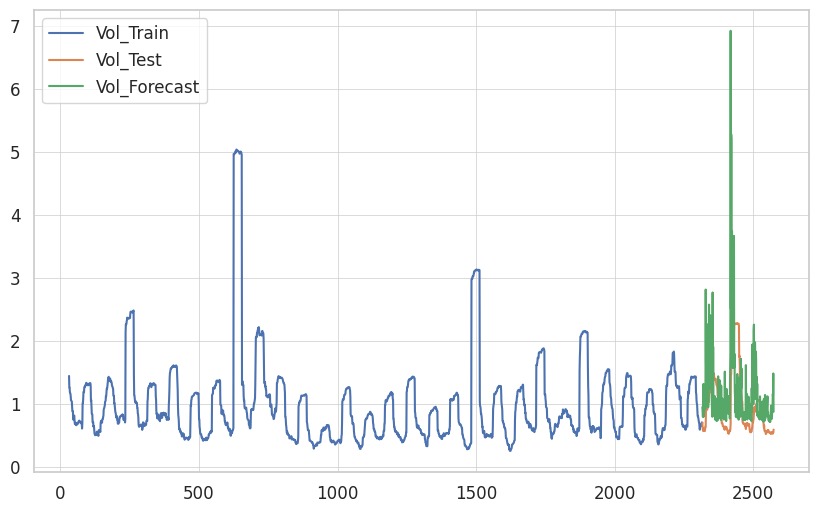

In [122]:
ar9garch12.forecast_vs_test_vol_plot()

## Strategy & Results

The forecasts were used to generate trading signals. Whenever the next period return was forecast to be positive, a long position was selected, otherwise a short position was selected. The position was only initiated if the next period volatility was forecast to be above the last observed volatility level, i.e. if a relatively large move in either direction was anticipated to increase the chances of profiting from the trade and avoiding unnecessary transaction costs.

Gross P&L was calculated based on the direction and realised return. Net P&L substracted trading costs (5 basis points of trade value) from this wherever there was a change in position day-on-day.

In [123]:
class strategy(garch):
    def __init__(self, proportion, approach, p, q, mean, data, asset, lags, o = 0):
        garch.__init__(self, proportion, approach, p, q, mean, data, asset, lags, o = 0)
        self.trade = self.build()
        
    def build(self):
        trade = self.forecast_vs_test
        print(self.last_train_date)

        close =  self.data[['JNJ']]
        trade = pd.merge(trade, close, left_index = True, right_index = True)
        
        last_train = trade.iloc[lambda x: x.index == self.last_train_date]
        last_vol_train = last_train['Vol_Train'].iloc[0]

        trade['direction'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Ret_Forecast'] > 0, 1, -1))
        trade['amplifier'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Vol_Forecast'] > last_vol_train, 1, 0))
        trade['position'] = trade['direction'] * trade['amplifier']
        trade['pnl_gross'] = trade['Ret_Test'] / 1000 * trade['position'] # adjust returns back to normal levels accounting for model scalar
        trade['pnl_gross_cum'] = trade['pnl_gross'].cumsum()
        trade['position_lag'] = trade['position'].shift(1)
        trade['cost'] = np.where(trade['position'] == trade['position_lag'], 0, TRANSACTION_COSTS * trade['JNJ']) # cost is 5bps of trade value
        trade['pnl_net'] = trade['pnl_gross'] - trade['cost']
        trade['pnl_net_cum'] = trade['pnl_net'].cumsum()
        
        trade = trade.iloc[lambda x: x.index >= self.last_train_date]
        
        return trade
    
    def pos(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['direction'].plot(label='Direction')
        self.trade['amplifier'].plot(label='Amplifier')
        self.trade['position'].plot(label='Position')
        self.trade['cost'].plot(label='Cost')

        plt.title('Trading Positions ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def pnl_gross(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_gross'].plot(label='Gross P&L')
        self.trade['pnl_gross_cum'].plot(label='Cumulative Gross P&L')

        plt.title('Trading Gross P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
    
    def pnl_net(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_net'].plot(label='Net P&L')
        self.trade['pnl_net_cum'].plot(label='Cumulative Net P&L')

        plt.title('Trading Net P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def sr(self):
        sr_gross = 252 ** 0.5 * np.mean(self.trade['pnl_gross']) / np.std(self.trade['pnl_gross'])
        sr_net = 252 ** 0.5 * np.mean(self.trade['pnl_net']) / np.std(self.trade['pnl_net'])
        
        return pd.DataFrame({'Metric': ['SR Gross', 'SR Net'], 'Value': [sr_gross, sr_net]})

In [124]:
ar9garch12_strat = strategy('roll1d', 0.9, 1, 2, 'AR', returns, 'Ret_JNJ', 9)

Iteration:      1,   Func. Count:     16,   Neg. LLF: 142408.81828828537
Iteration:      2,   Func. Count:     36,   Neg. LLF: 11821321.537696928
Iteration:      3,   Func. Count:     54,   Neg. LLF: 141619741.40669888
Iteration:      4,   Func. Count:     72,   Neg. LLF: 1199931.9879678087
Iteration:      5,   Func. Count:     89,   Neg. LLF: 2405569.4319773437
Iteration:      6,   Func. Count:    105,   Neg. LLF: 17263027.95102325
Iteration:      7,   Func. Count:    122,   Neg. LLF: 17937.852518408086
Iteration:      8,   Func. Count:    140,   Neg. LLF: 13584.148050944752
Iteration:      9,   Func. Count:    158,   Neg. LLF: 17029.57502359087
Iteration:     10,   Func. Count:    176,   Neg. LLF: 8388.460968971425
Iteration:     11,   Func. Count:    193,   Neg. LLF: 3867.7838429741555
Iteration:     12,   Func. Count:    209,   Neg. LLF: 6298.533612131359
Iteration:     13,   Func. Count:    226,   Neg. LLF: 11531.41715935291
Iteration:     14,   Func. Count:    244,   Neg. LLF: 49

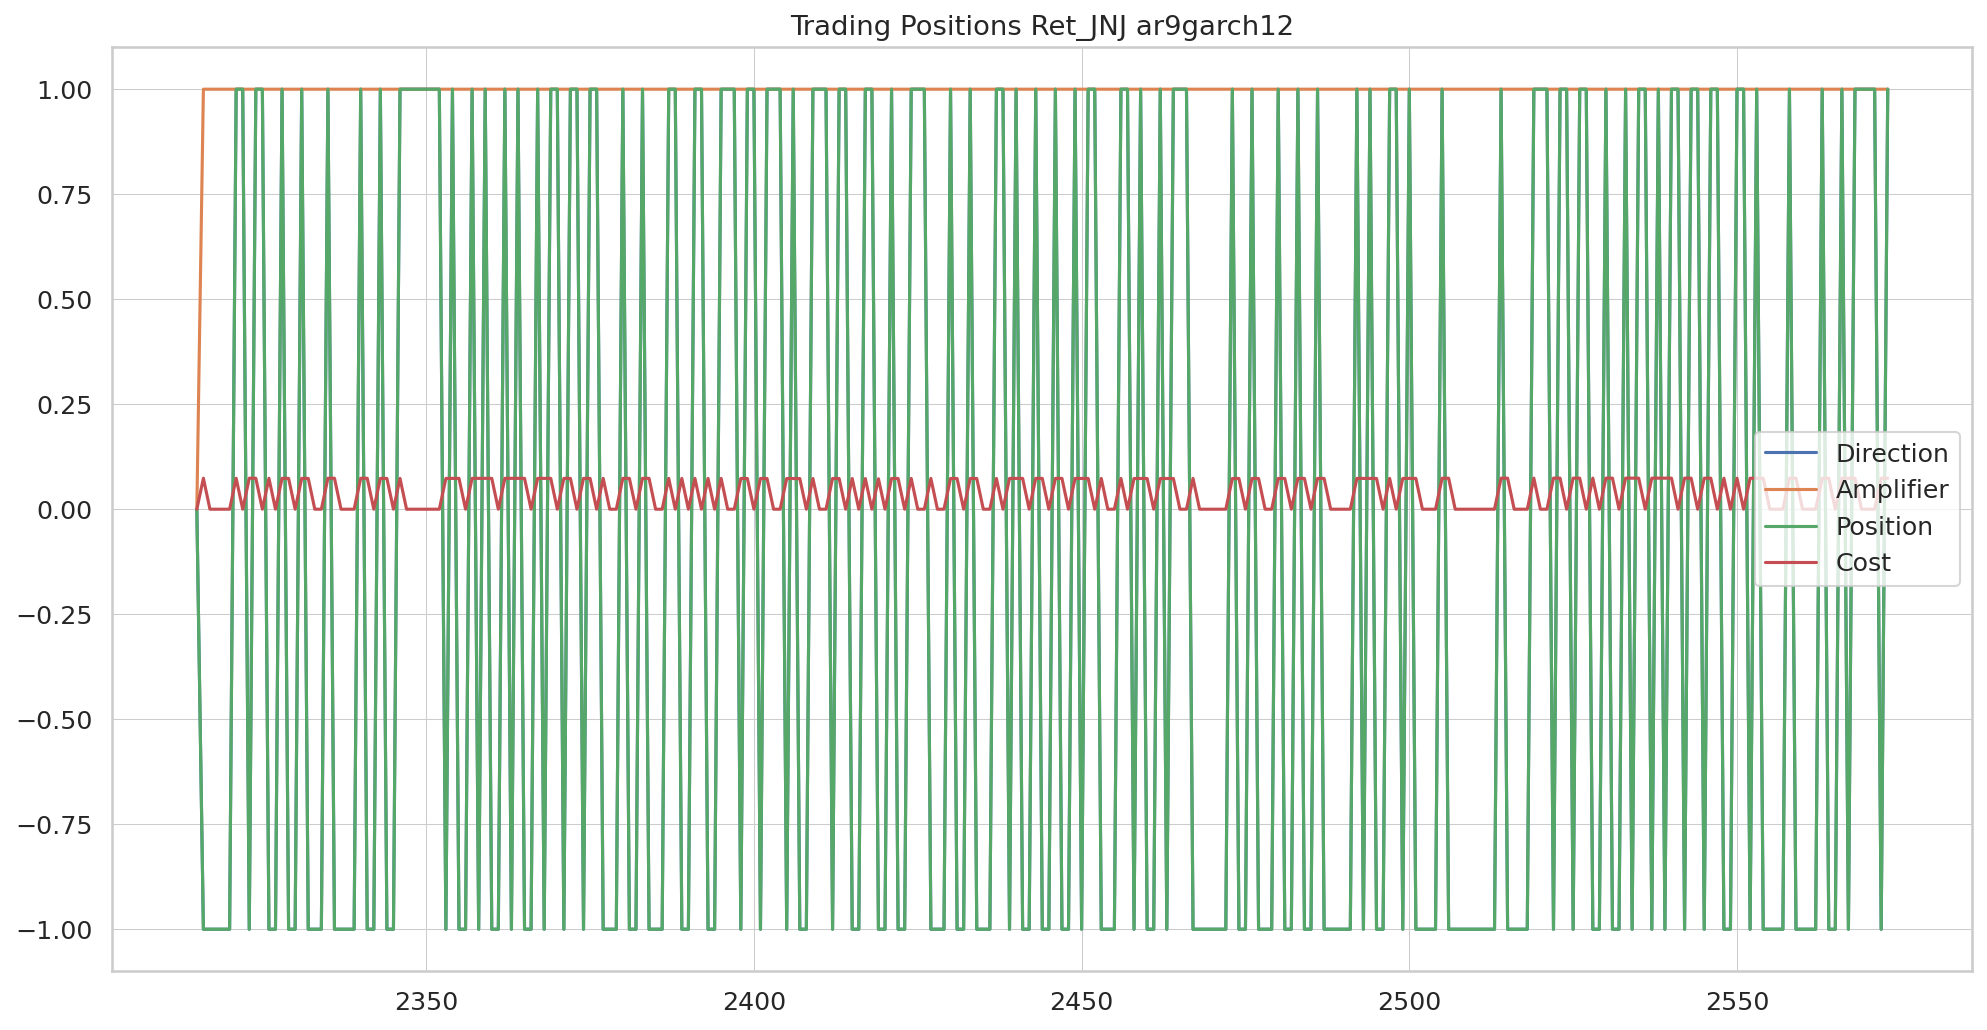

In [125]:
ar9garch12_strat.pos()

The strategy resulted in frequent trades, often switching positions between long and short. These were always triggered due to the volatility forecast always exceeding the last observed level of volatility. The volatility forecast was inaccurate in line with lack of arch effects and no statistically significant squared log returns observed earlier. The frequent execution of trades implied high trading costs.

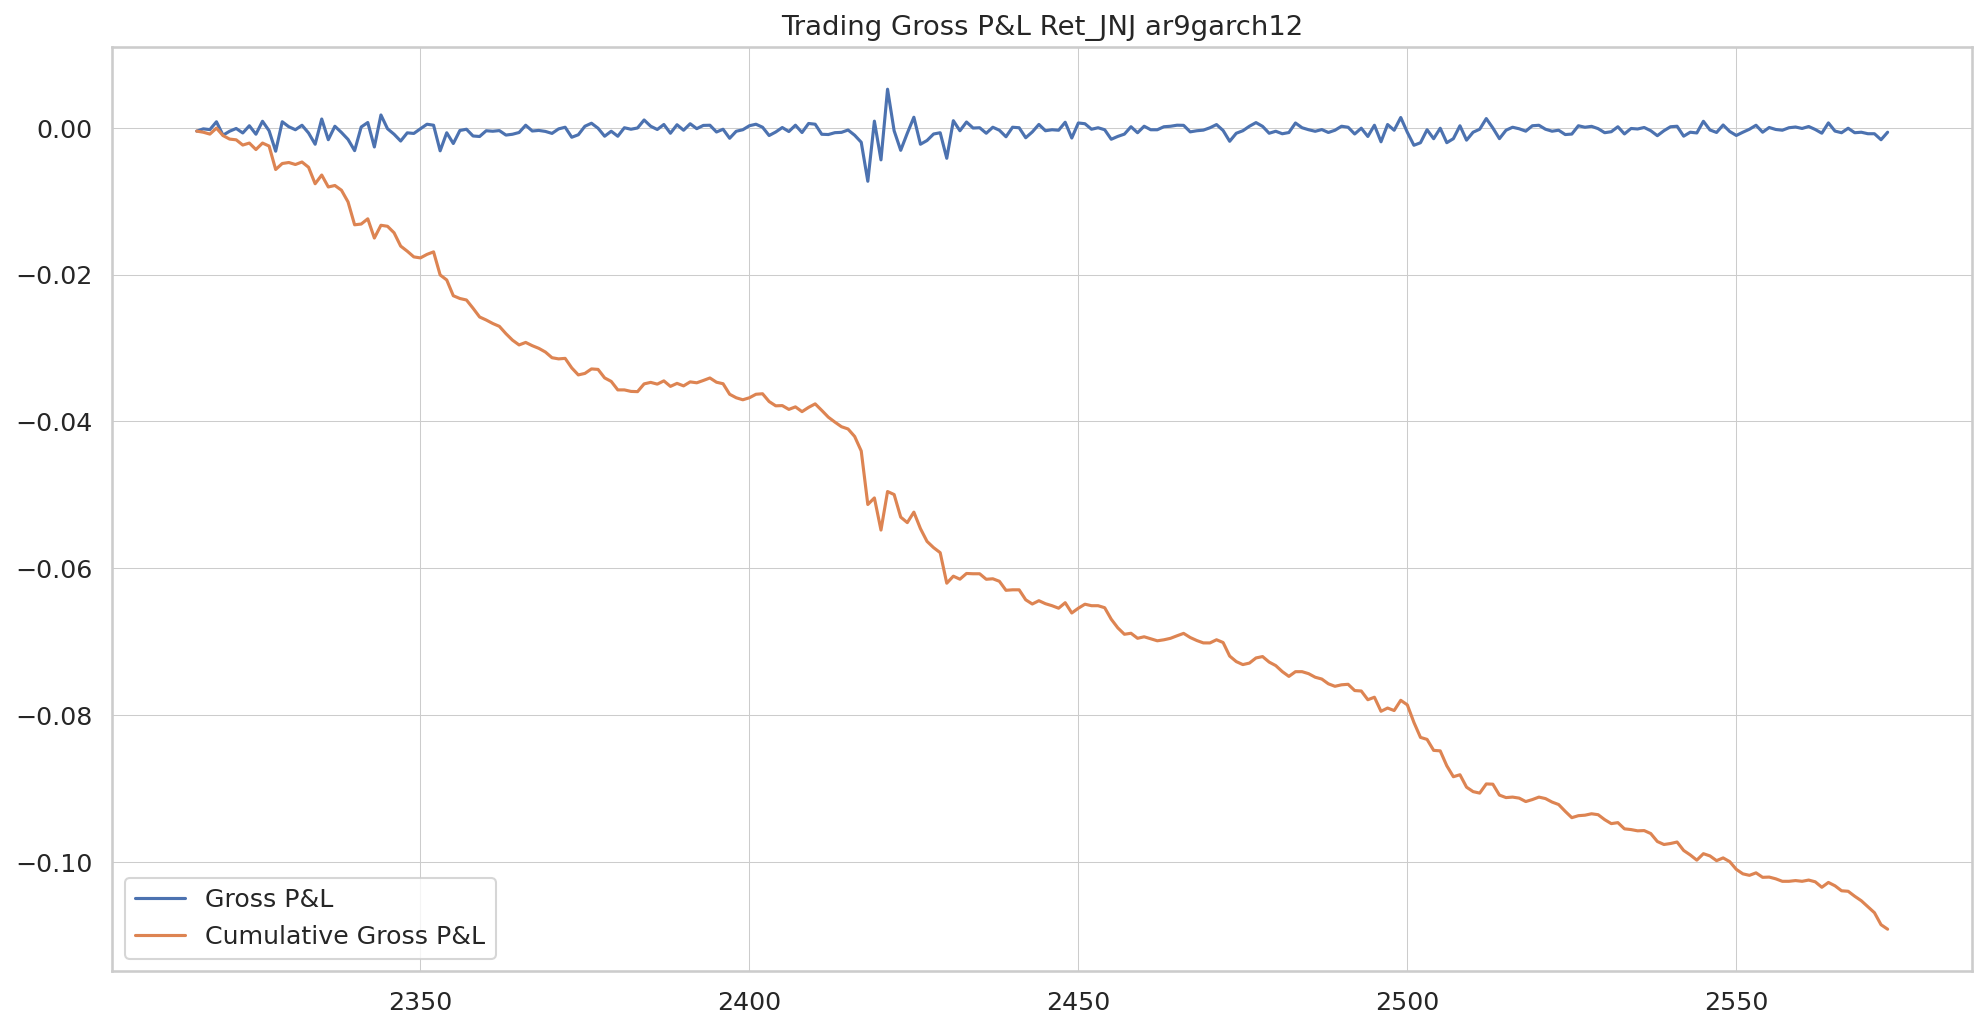

In [126]:
ar9garch12_strat.pnl_gross()

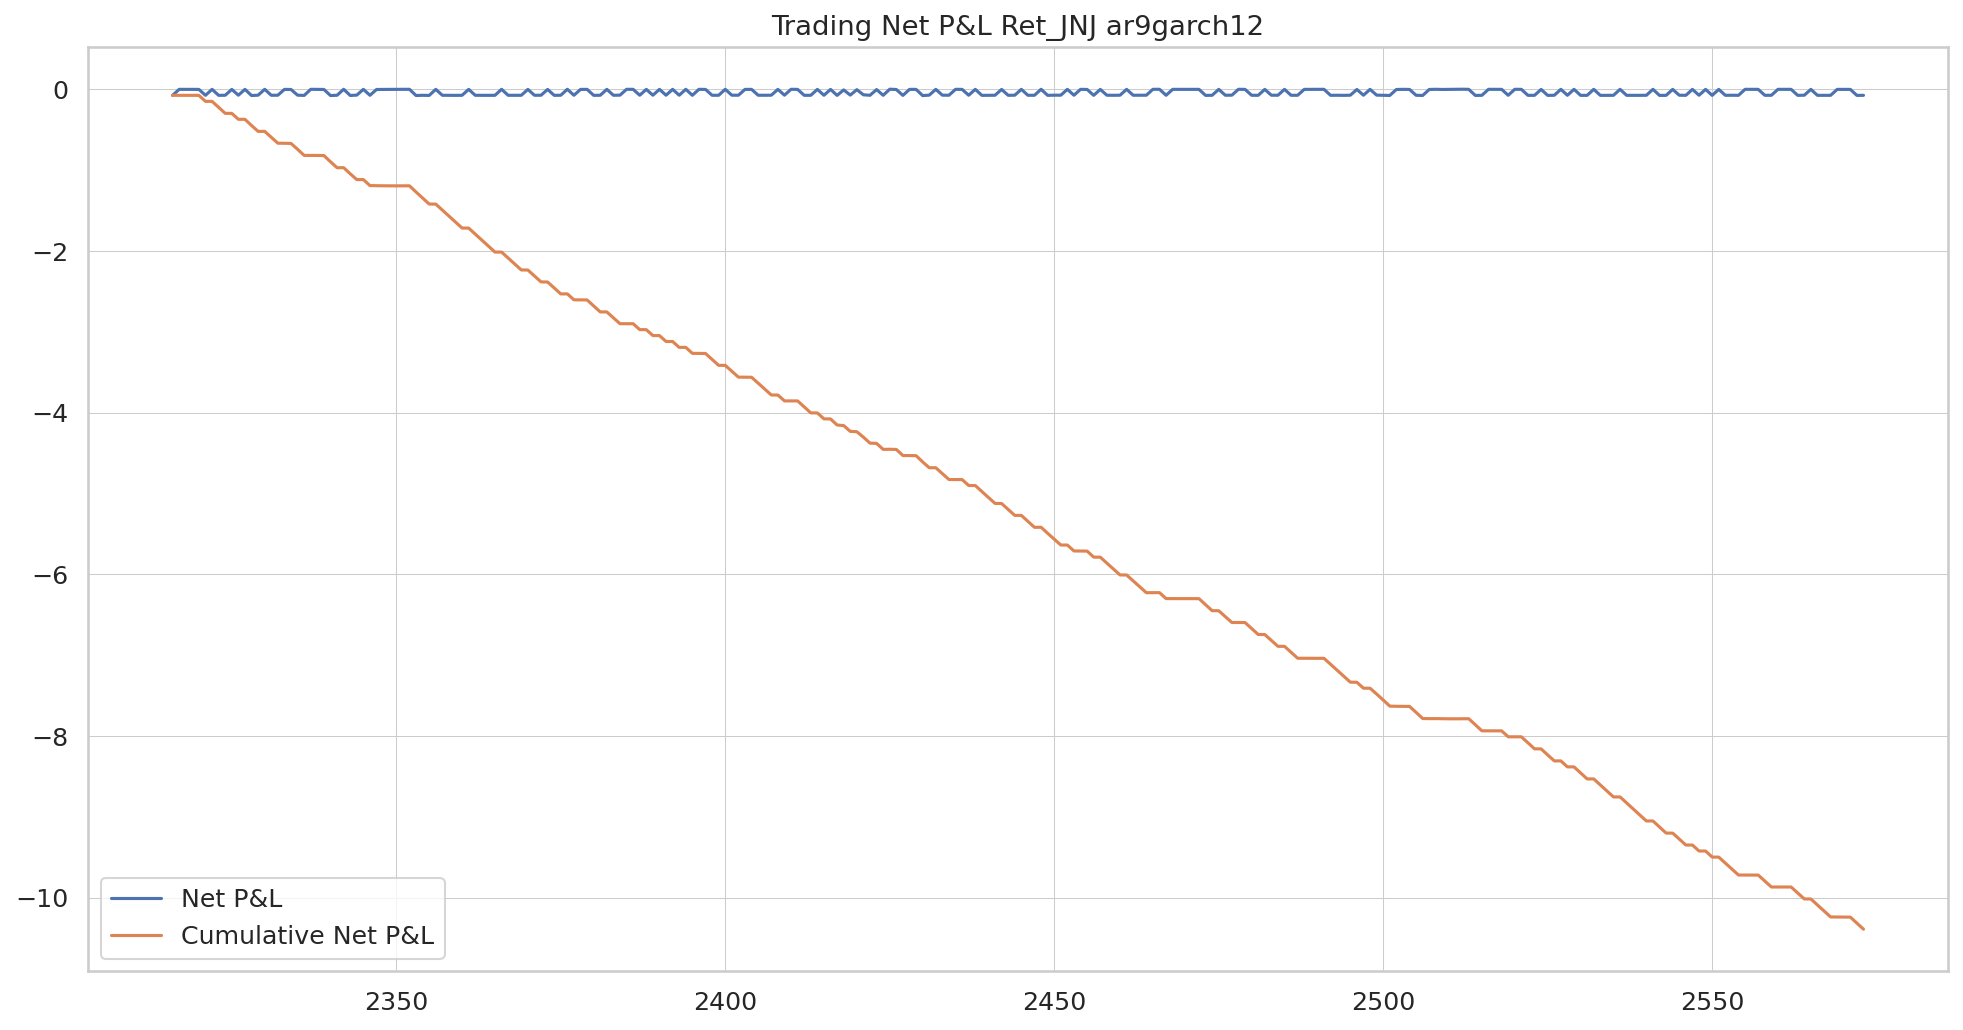

In [127]:
ar9garch12_strat.pnl_net()

As expected, net cumulative P&L was negative. Gross cumulative P&L was also negative, which suggests being in the market (momentum strategy) based on recently observed returns is not a profitable strategy. A mean-reversion strategy may have performed better.

In [128]:
ar9garch12_strat.sr()

,Metric,Value
0,SR Gross,-6.581488
1,SR Net,-17.505621


As a result, the net Sharpe ratio on the test set was -17.5.

# Data: LSTM

LSTM (Long Short Term Memory) was the second model for performing univariate prediction of the time series of Johnson & Johnson equity price.

In [129]:
# Shared processing imports start here...
import numpy as np                  # General purpose math
import pandas as pd                 # Dataframes
import matplotlib.pyplot as plt     # Simple plotting
# End of shared processing imports.

# LSTM processing imports start here...
import tensorflow as tf                                 # LSTM support
from tensorflow.keras.layers import LSTM                # LSTM model definition
from tensorflow.keras.models import Sequential          # Sequential LSTM layer
from tensorflow.keras.layers import Dense               # Dense LSTM layer
from sklearn.preprocessing import MinMaxScaler          # Transforming the observations to a specific range
from sklearn.model_selection import train_test_split    # Enabling out-of-sample validation
from sklearn.metrics import mean_squared_error          # Model evaluation
import quantstats as qs                                 # calculating ratios
# End of LSTM processing imports.

In [130]:
jnj_close = pd.read_csv('../jnj.us.txt')[["<DATE>", "<TIME>", "<OPEN>", "<CLOSE>"]].rename(columns={'<DATE>' :  'Date',
                                                                                                    '<TIME>':   'Time',
                                                                                                    '<OPEN>':   'Open',
                                                                                                    '<CLOSE>':  'Close'})
jnj_close.head()

,Date,Time,Open,Close
0,20240419,153000,146.150,144.8000
1,20240419,153500,144.800,145.4200
2,20240419,154000,145.440,145.6200
3,20240419,154500,145.660,145.9858
4,20240419,155000,145.975,146.1800


The date and time information was split between two columns. A single column unifying the two was created to allow for later construction of a timestamp.

In [131]:
jnj_close['Datetime String'] = jnj_close.Date.map(str) + " " + jnj_close.Time.map(str)
jnj_close.head()

,Date,Time,Open,Close,Datetime String
0,20240419,153000,146.150,144.8000,20240419 153000
1,20240419,153500,144.800,145.4200,20240419 153500
2,20240419,154000,145.440,145.6200,20240419 154000
3,20240419,154500,145.660,145.9858,20240419 154500
4,20240419,155000,145.975,146.1800,20240419 155000


In [132]:
jnj_close['Datetime'] = pd.to_datetime(jnj_close['Datetime String'], format='%Y%m%d %H%M%S')  
jnj_close = jnj_close.set_index('Datetime').drop(columns=['Datetime String', 'Date', 'Time']) 

jnj_close.head()

,Open,Close
Datetime,,
2024-04-19 15:30:00,146.150,144.8000
2024-04-19 15:35:00,144.800,145.4200
2024-04-19 15:40:00,145.440,145.6200
2024-04-19 15:45:00,145.660,145.9858
2024-04-19 15:50:00,145.975,146.1800


The 'Close' variable was the target for predicting. The prediction model had to operate on lagged open/close variables to ensure look-ahead bias was eliminated.

In [133]:
jnj_close['Open Lag']   = jnj_close['Open'].shift(6)
jnj_close['Close Lag']  = jnj_close['Close'].shift(6)
jnj_close.head(10)

,Open,Close,Open Lag,Close Lag
Datetime,,,,
2024-04-19 15:30:00,146.150,144.8000,NaN,NaN
2024-04-19 15:35:00,144.800,145.4200,NaN,NaN
2024-04-19 15:40:00,145.440,145.6200,NaN,NaN
2024-04-19 15:45:00,145.660,145.9858,NaN,NaN
2024-04-19 15:50:00,145.975,146.1800,NaN,NaN
2024-04-19 15:55:00,146.180,146.0800,NaN,NaN
2024-04-19 16:00:00,146.090,145.8450,146.15,144.8000
2024-04-19 16:05:00,145.830,146.1700,144.80,145.4200
2024-04-19 16:10:00,146.170,146.3000,145.44,145.6200


In [134]:
jnj_close = jnj_close.dropna()

# Methodology: LSTM

## Model

The model building process was started by affixing the random seed for reproducibility.

In [135]:
tf.random.set_seed(7)

LSTMs are sensitive to input data scale. Dataframe values were normalised before fitting the model to ensure best performance. 

In [136]:
scaler = MinMaxScaler(feature_range=(0, 1))
jnj_close = pd.DataFrame(scaler.fit_transform(jnj_close), index=jnj_close.index, columns=jnj_close.columns)
jnj_close.head()

,Open,Close,Open Lag,Close Lag
Datetime,,,,
2024-04-19 16:00:00,0.209603,0.169242,0.215143,0.070714
2024-04-19 16:05:00,0.185596,0.199885,0.090489,0.129171
2024-04-19 16:10:00,0.216990,0.212142,0.149584,0.148028
2024-04-19 16:15:00,0.230840,0.200828,0.169898,0.182518
2024-04-19 16:20:00,0.218375,0.213556,0.198984,0.200828


The model was validated on a portion of the dataset which was not used for training. A "train-test" split was performed.
Additionally, the focus was on close price prediction only (lagged open values remained as features).

In [137]:
X = jnj_close[['Open Lag', 'Close Lag']] # Notice how the 'Open' column is implicitly dropped, unused.
y = jnj_close[['Close']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train.head()

,Open Lag,Close Lag
Datetime,,
2024-06-07 17:30:00,0.384340,0.350742
2024-05-07 20:50:00,0.462604,0.453513
2024-04-24 18:05:00,0.332410,0.315385
2024-04-22 17:30:00,0.495845,0.482741
2024-04-24 17:25:00,0.286242,0.305956


LSTMs require 3-dimensional inputs in the form of [samples, timesteps, features]. Inputs were reshaped.

In [138]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

An LSTM model was defined with multiple intermediate Dense layers. This increased both model accuracy and overall training time. It was then fitted.

In [139]:
model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(1,2)))
model.add(Dense(2))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

/home/stanisz/Documents/programming/ATS_project/venv/lib64/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [140]:
fitting_history = model.fit(X_train, y_train, epochs=15, batch_size=3, verbose=2)

Epoch 1/15
771/771 - 4s - 5ms/step - loss: 0.0467
Epoch 2/15
771/771 - 2s - 2ms/step - loss: 0.0027
Epoch 3/15
771/771 - 2s - 2ms/step - loss: 0.0020
Epoch 4/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 5/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 6/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 7/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 8/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 9/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 10/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 11/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 12/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 13/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 14/15
771/771 - 2s - 2ms/step - loss: 0.0019
Epoch 15/15
771/771 - 2s - 2ms/step - loss: 0.0019


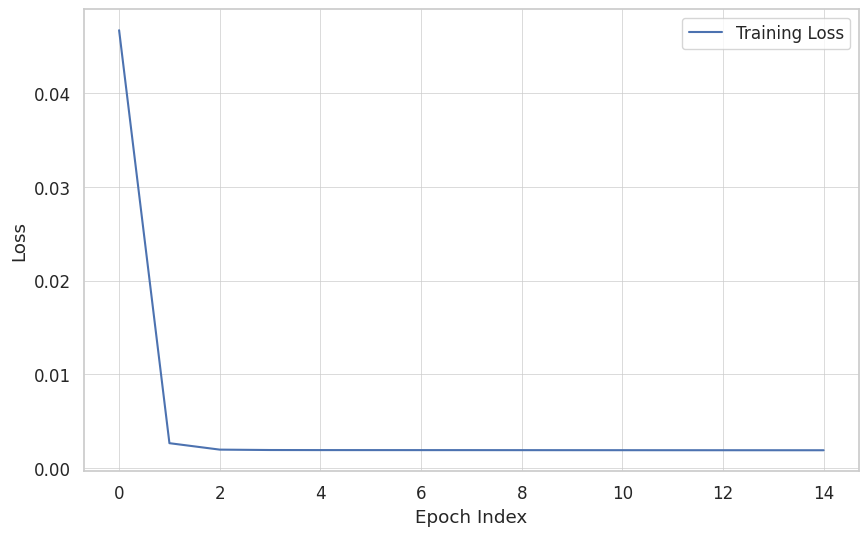

In [141]:
_, ax = plt.subplots()
ax.plot(fitting_history.history['loss'], label='Training Loss')
ax.set_xlabel('Epoch Index')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

The model fitting history shows that the loss quickly diminished and remained constant after the initial epochs. 

In [142]:
testPredict = model.predict(X_test)[:,1]
testPredict = testPredict.reshape(len(testPredict), 1)

trainPredict = model.predict(X_train)[:,1]
trainPredict = trainPredict.reshape(len(trainPredict), 1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [143]:
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 0.0435 RMSE
Test Score: 0.0371 RMSE


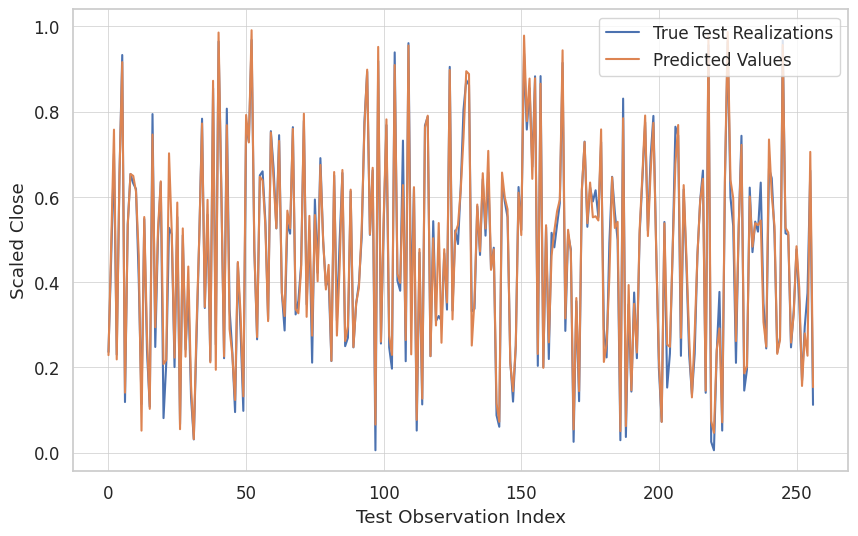

In [144]:
_, ax = plt.subplots()
ax.plot(y_test.values, label='True Test Realizations')
ax.plot(testPredict, label='Predicted Values')
ax.set_xlabel('Test Observation Index')
ax.set_ylabel('Scaled Close')
plt.legend()
plt.show()

As seen on the figure above, predictions of the scaled close price were very accurate. The test score was only slightly worse than the train score (as expected), which meant that the procedure did not overfit the model. 

## Strategy & Results

The strategy was to set a long position when the model predicted a positive return. It did nothing if the predicted return was negative to limit trading frequency.

Firstly, the test sample data was arranged into a data frame, because LSTM forced data into numpy arrays above. The below dataframe still operated on scaled (to [0,1]) values.

In [145]:
lstm_strategy = pd.DataFrame(data=[y_test.values.T[0], testPredict.T[0]]).transpose()
lstm_strategy.columns = columns=['True', 'Predicted']
lstm_strategy.head()

,True,Predicted
0,0.236232,0.228875
1,0.461055,0.493040
2,0.701483,0.757850
3,0.230056,0.218773
4,0.653398,0.653928


The scaling applied on the dataset was inverted to get the actual values of the close price.

In [146]:
predicted = testPredict.T[0].reshape(-1, 1)
predicted = np.c_[ predicted, predicted, predicted, predicted ] # The original transform had 4 features, we only need one. But we need to match the shape...  
predicted = scaler.inverse_transform(predicted)[:,1]

actual = y_test.values.T[0].reshape(-1, 1)
actual = np.c_[ actual, actual, actual, actual ] 
actual = scaler.inverse_transform(actual)[:,1]

In [147]:
lstm_strategy = pd.DataFrame(data=[actual, predicted]).transpose()
lstm_strategy.columns = columns=['True', 'Predicted']
lstm_strategy.head()

,True,Predicted
0,146.5555,146.477478
1,148.9400,149.279236
2,151.4900,152.087830
3,146.4900,146.370331
4,150.9800,150.985626


Predicted and true returns on the out-of-sample test period were calculated. 

In [148]:
lstm_strategy['Predicted Return'] = (lstm_strategy['Predicted'] - lstm_strategy['Predicted'].shift(1)).shift(-1)
lstm_strategy['True Return'] = (lstm_strategy['True'] - lstm_strategy['True'].shift(1)).shift(-1)

lstm_strategy = lstm_strategy.dropna()
lstm_strategy.head()

,True,Predicted,Predicted Return,True Return
0,146.5555,146.477478,2.801758,2.3845
1,148.9400,149.279236,2.808594,2.5500
2,151.4900,152.087830,-5.717499,-5.0000
3,146.4900,146.370331,4.615295,4.4900
4,150.9800,150.985626,2.782455,2.9650


The signal was defined to equal 1 only if predicted one-day return was positive. The strategy did not trade otherwise.

In [149]:
lstm_strategy = lstm_strategy.assign(signal = lambda row: row['Predicted Return'] > 0)
lstm_strategy.head()

,True,Predicted,Predicted Return,True Return,signal
0,146.5555,146.477478,2.801758,2.3845,True
1,148.9400,149.279236,2.808594,2.5500,True
2,151.4900,152.087830,-5.717499,-5.0000,False
3,146.4900,146.370331,4.615295,4.4900,True
4,150.9800,150.985626,2.782455,2.9650,True


Strategy returns were defined to equal the actual returns obtained in the market that time less transaction costs defined above. It should be noted that the time index represented 5-minute observations. The evaluation period was therefore short.

In [150]:
lstm_strategy = lstm_strategy.assign(strategy_gross_returns = lambda row: row['signal'] * row['True Return'])
lstm_strategy['Did Position Change'] = (lstm_strategy['signal'].shift(1) == False) & (lstm_strategy['signal'] == True) # Am I assuming a new long position?
lstm_strategy = lstm_strategy.assign(strategy_net_returns = lambda row: row['strategy_gross_returns'] - row['Did Position Change'] * TRANSACTION_COSTS * row['True'])
lstm_strategy['Cumulative Gross Returns'] = lstm_strategy.cumsum()['strategy_gross_returns']
lstm_strategy['Cumulative Net Returns'] = lstm_strategy.cumsum()['strategy_net_returns']
lstm_strategy.head(10)

,True,Predicted,Predicted Return,True Return,signal,strategy_gross_returns,Did Position Change,strategy_net_returns,Cumulative Gross Returns,Cumulative Net Returns
0,146.5555,146.477478,2.801758,2.3845,True,2.3845,False,2.384500,2.3845,2.384500
1,148.9400,149.279236,2.808594,2.5500,True,2.5500,False,2.550000,4.9345,4.934500
2,151.4900,152.087830,-5.717499,-5.0000,False,-0.0000,False,-0.000000,4.9345,4.934500
3,146.4900,146.370331,4.615295,4.4900,True,4.4900,True,4.416755,9.4245,9.351255
4,150.9800,150.985626,2.782455,2.9650,True,2.9650,False,2.965000,12.3895,12.316255
5,153.9450,153.768082,-8.224365,-8.6350,False,-0.0000,False,-0.000000,12.3895,12.316255
6,145.3100,145.543716,4.159760,4.4300,True,4.4300,True,4.357345,16.8195,16.673600
7,149.7400,149.703476,1.281158,1.2450,True,1.2450,False,1.245000,18.0645,17.918600
8,150.9850,150.984634,-0.047119,-0.2350,False,-0.0000,False,-0.000000,18.0645,17.918600
9,150.7500,150.937515,-0.393753,-0.1400,False,-0.0000,False,-0.000000,18.0645,17.918600


Strategy results were plotted against true and predicted returns. They included transaction costs defined above.

<Axes: >

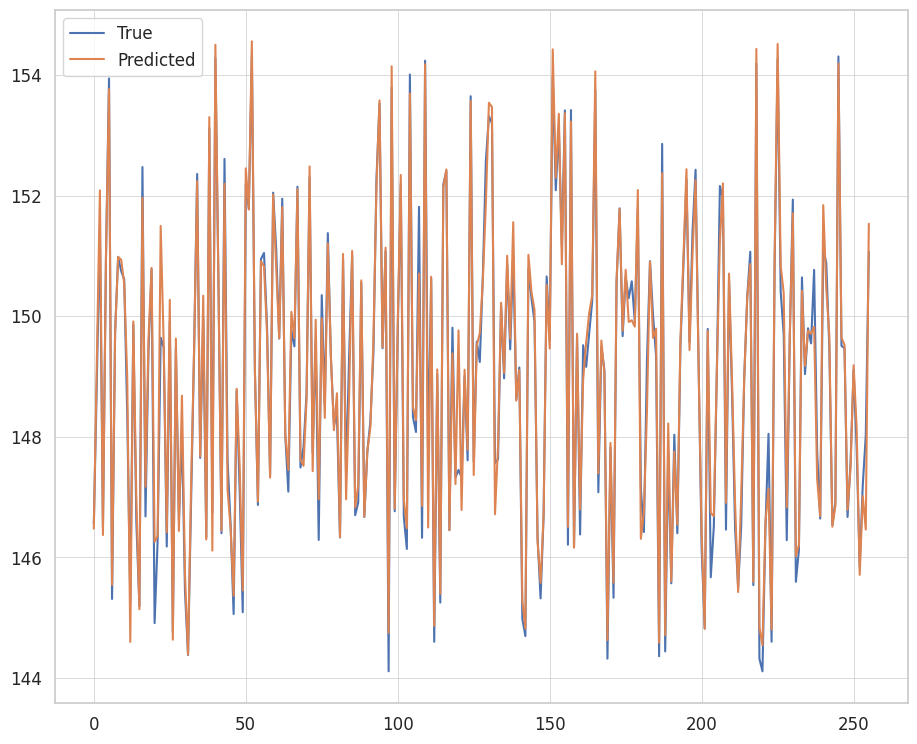

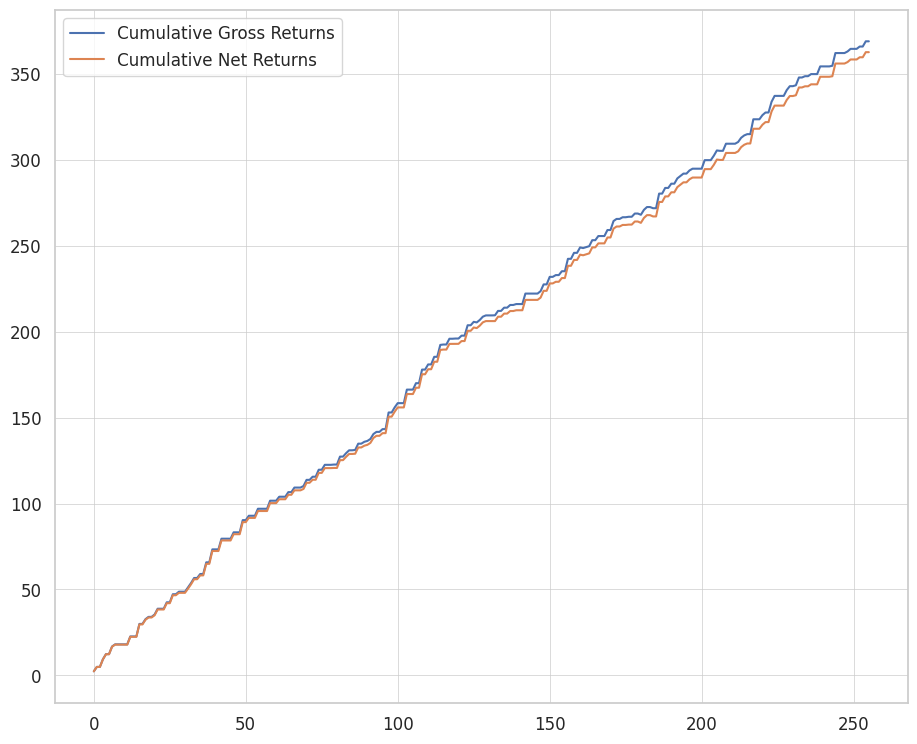

In [151]:
lstm_strategy[['True', 'Predicted']].plot(figsize=(11,9))
lstm_strategy[['Cumulative Gross Returns', 'Cumulative Net Returns']].plot(figsize=(11,9))

The LSTM model was assessed using the total Sharpe Ratio on the out-of-sample test period. Simple statistics on the number of performed trades were calculated.

In [152]:
lstm_number_of_trades = lstm_strategy.cumsum()['signal'].iloc[-1]
lstm_proportion_of_trades = lstm_number_of_trades / len(lstm_strategy)
print(f"LSTM model made {lstm_number_of_trades} trades, it traded {lstm_proportion_of_trades:.{2}}% of times on average.")

LSTM model made 130 trades, it traded 0.51% of times on average.


In [153]:
lstm_sharpe = qs.stats.sharpe(lstm_strategy[['Cumulative Net Returns']])[0]
print(f"LSTM model total Net Sharpe Ratio is equal to {lstm_sharpe:.{3}}")

LSTM model total Net Sharpe Ratio is equal to 3.79


/tmp/ipykernel_6274/3507800921.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lstm_sharpe = qs.stats.sharpe(lstm_strategy[['Cumulative Net Returns']])[0]


The Sharpe ratio was very high. Even including transaction costs, the strategy generated profits steadily and, because it traded only long, the variance of cumulative returns was very low. 

# Conclusion

The underlying series of Johnson & Johnson equity returns displayed leptokurtic and autoregressive properties across the 19/04/2024-07/06/2024 period, assuming 5-minute prices.

The AR(9)-GARCH(1,2) model produced poor results despite the confirmed persistence of returns. The GARCH component was not able to forecast volatility sufficiently which triggered too many costly trades. The reaction to the signals was inappropriate for the frequency of data used - a mean-reversion strategy and a longer interval between observations may have been beneficial at increasing the -17.5 Sharpe ratio.

The LSTM model performed very well with an impressive Sharpe ratio of 3.79. The high result was attributed to the specification of the LSTM model, which captured short relationships in time very well. The diminishing gradients problem did not affect the prediction adversely. Additionally, the forecasting period of the stock was very stable and behaved like a mean-reverting process. Such a relationship was easily discovered by the model with a dense neural layer, as it effectively partially reduced to a scalar multiplication by -1. The model results could have been worse during a more volatile and trending period on the market. Nonetheless, the model results were impressive and were a good choice for a calm market.

# References

- https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity
- https://arch.readthedocs.io/en/latest/univariate/introduction.html
- https://www.statsmodels.org/stable/index.html
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://stackoverflow.com/questions/8486294/how-do-i-add-an-extra-column-to-a-numpy-array
- https://pypi.org/project/QuantStats/
- https://stackoverflow.com/questions/57216718/how-to-inverse-transform-the-predicted-values-in-a-multivariate-time-series-lstm
- https://en.wikipedia.org/wiki/Long_short-term_memory

# Distribution of Work

Distribution of work matches our initial division of work from the project proposal. In general:

Adam:
 - GitHub repo setup
 - Definition of classes used in the first trading strategy
 - Descriptive statistics of the dataset 
 - Implementation and testing of AR-GARCH
 - Evalutation of the AR-GARCH, plotting results and strategy returns

Maciek:
 - Data download
 - Reading and preparing the time series
 - Implementation and testing of the LSTM model
 - Evaluation of LSTM, plotting results and strategy returns 